#  Autonomous JIRA Incident Creation System for AWS
---


In this project, you will build an Agentic system that automatically responds to incidents in your AWS accounts using a multi-agent workflow. This system is designed to handle monitoring, analysis, and resolution with minimal manual intervention, helping you manage security and operational issues efficiently.

The system is composed of four main components:

1️⃣ Monitoring Agent
This part uses an automated tool to fetch CloudWatch logs from your AWS account for the services you care about, such as IAM, S3, EC2 etc. It helps collect real-time data on activities and potential issues within your environment, which is essential for identifying anomalies or failures quickly.

2️⃣ Diagnosis Agent
Once the logs are collected, the Diagnosis Agent analyzes the information provided by the Monitoring Agent to identify potential security risks, misconfigurations, or compliance issues. It then uses a web search tool to find remediation steps and best practices, creates a detailed diagnostic report, and prepares it for the resolution phase.

3️⃣ Resolution Agent
Triggered after the diagnosis phase, the Resolution Agent takes the diagnostic report and uses it to create a Jira ticket. This ticket will include a clear description of the identified issue along with recommended remediation steps, ensuring that your team or stakeholders can take action promptly.

4️⃣ Observability and Tracing
Throughout the entire workflow, the system uses tracing and observability tools like LangSmith to track what each agent is doing. This makes it easier to debug, monitor progress, and ensure transparency in the automated incident response process.


In [ ]:
# ====================================================
# Load and set required environment variables for:
#    - AWS SDK authentication (Bedrock, S3, etc.)
#    - Tavily API usage
#    - Jira API integration for automated ticketing
# ====================================================
import os 
from dotenv import load_dotenv
load_dotenv(override=True)
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_API_KEY"]= os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"]=os.getenv("LANGCHAIN_PROJECT")

os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")
os.environ["AWS_REGION"] = os.getenv("AWS_REGION")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

os.environ["JIRA_API_TOKEN"] = os.getenv("JIRA_API_TOKEN")
os.environ["JIRA_USER_EMAIL"] = os.getenv("JIRA_USERNAME")
os.environ["JIRA_INSTANCE_URL"] = os.getenv("JIRA_INSTANCE_URL")
os.environ["JIRA_CLOUD"] = "True"
os.environ['PROJECT_KEY']  = os.getenv("PROJECT_KEY", "BTS")

In [ ]:
# import general packages 
import boto3
import logging 
import json
from datetime import datetime, timedelta, timezone
from typing import Annotated, List, Dict, Any, Optional, Union, Literal
from typing_extensions import TypedDict
from langsmith import traceable
from pydantic import BaseModel

# import langgraph relavant packages 
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages

# checkpointing for agent memory 
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent

# langchain imports
from langchain_aws.chat_models import ChatBedrockConverse
from langchain_core.tools import BaseTool, tool
from langchain.tools.tavily_search import TavilySearchResults
from langchain_community.utilities import JiraAPIWrapper
from langchain_core.messages import BaseMessage
from langchain.tools import Tool, StructuredTool
 
#langsmith import 
from langsmith import Client
from langsmith import traceable

from colorama import init, Fore, Style
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage


## Define Logger Formatting Requirements
---

In [3]:
# Initialize colorama
init()

# Set up a logger for pretty printing
logger = logging.getLogger("aws_monitoring_workflow")
logger.setLevel(logging.INFO)

# Remove any existing handlers to avoid duplicate logs
if logger.hasHandlers():
    for handler in logger.handlers:
        logger.removeHandler(handler)

# Add a new handler with formatting
handler = logging.StreamHandler()
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

def pretty_print_messages(node_output):
    """Format and print only essential messages: tools, AI responses, and agent names."""
    if isinstance(node_output, dict) and "messages" in node_output:
        messages = node_output["messages"]
        for msg in messages:
            # Skip any error-related messages
            if isinstance(msg, dict):  # Handle dict-formatted messages
                role = msg.get("role", "")
                content = msg.get("content", "")
                
                # Only print AI messages
                if role == "assistant" or role == "ai":
                    logger.info(f"{Fore.BLUE}[AI] {content}{Style.RESET_ALL}")
                # Only print tool calls
                elif role == "tool":
                    tool_name = msg.get("name", "tool")
                    logger.info(f"{Fore.YELLOW}[TOOL: {tool_name}] Called{Style.RESET_ALL}")
            
            # Handle LangChain message objects
            elif isinstance(msg, (AIMessage, ToolMessage)):
                if isinstance(msg, AIMessage):
                    logger.info(f"{Fore.BLUE}[AI] {msg.content}{Style.RESET_ALL}")
                elif isinstance(msg, ToolMessage):
                    logger.info(f"{Fore.YELLOW}[TOOL: {msg.name}] Called{Style.RESET_ALL}")
    
    # Print the agent name if available
    if isinstance(node_output, dict) and "agent_name" in node_output:
        logger.info(f"{Fore.MAGENTA}[AGENT: {node_output['agent_name']}]{Style.RESET_ALL}")
    
    # For supervisor or other non-message nodes
    if isinstance(node_output, dict) and "node_type" in node_output:
        logger.info(f"{Fore.CYAN}[NODE: {node_output['node_type']}]{Style.RESET_ALL}")

In [4]:
# define the model from Bedrock
AMAZON_NOVA_PRO_MODEL_ID: str = 'us.amazon.nova-pro-v1:0'
AMAZON_NOVA_MICRO_MODEL_ID: str = 'us.amazon.nova-micro-v1:0'
META_LLAMA_3_2_11B_VISION_INSTRUCT: str = 'us.meta.llama3-2-11b-instruct-v1:0'

In [5]:
# let's define the LLM that will be used to power the monitoring agent
llm = ChatBedrockConverse(
    model_id = AMAZON_NOVA_MICRO_MODEL_ID, 
    temperature = 0.1,
)

logger.info(f"Initialized the LLM: {llm}")

Initialized the LLM: client=<botocore.client.BedrockRuntime object at 0x7f270025cfe0> model_id='us.amazon.nova-micro-v1:0' temperature=0.1 aws_access_key_id=SecretStr('**********') aws_secret_access_key=SecretStr('**********') provider='amazon' supports_tool_choice_values=('auto', 'any', 'tool')


#### Define monitoring tools for Monitoring Agent
---

In [118]:
# Set up logging
logger = logging.getLogger(__name__)

# Define boto3 and AWS client services
cloudwatch_client = boto3.client('cloudwatch')
cloudtrail_client = boto3.client('cloudtrail')
logs_client = boto3.client('logs')
xray_client = boto3.client('xray')
autoscaling_client = boto3.client('autoscaling')
ec2_client = boto3.client('ec2')
health_client = boto3.client('health')
s3_client = boto3.client('s3')


class FetchLogsInput(BaseModel):
    service_name: str
    days: Optional[int] = 3
    filter_pattern: Optional[str] = '"ERROR" OR "FAILURE" OR "DENIED" OR "COMPLIANCE" OR "POLICY" OR "DeleteUser" OR "CreateUser" OR "AttachRolePolicy" OR "RemoveUserFromGroup"'


@traceable(run_type="tool", name="fetch_cloudwatch_logs_for_service")
def fetch_cloudwatch_logs_for_service(
    service_name: str,
    days: int = 3,
    filter_pattern: str = ""
) -> Dict[str, Any]:
    """
    Fetches CloudWatch logs for a specified service for the given number of days.
    
    Args:
        service_name (str): The name of the service to fetch logs for (e.g., "ec2", "lambda", "rds")
        days (int): Number of days of logs to fetch (default: 3)
        filter_pattern (str): Optional CloudWatch Logs filter pattern
        
    Returns:
        Dictionary with log groups and their recent log events
    """
    try:
        # Map service name to potential log group prefixes
        service_log_prefixes = {
            "ec2": ["/aws/ec2", "/var/log"],
            "lambda": ["/aws/lambda"],
            "apigateway": ["/aws/apigateway"],
            "cloudtrail": ["/aws/cloudtrail"],
            "s3": ["/aws/s3", "/aws/s3-access"],
            "bedrock": ["/bedrockInvocationlogs"], 
            "iam": ['/aws/cloudtrail']
        }
        
        # Default to searching all log groups if service isn't in our mapping
        prefixes = service_log_prefixes.get(service_name.lower(), [""])
        print(f"Fetching logs for the service: {prefixes}")
        
        # Find all log groups for this service
        log_groups = []
        for prefix in prefixes:
            paginator = logs_client.get_paginator('describe_log_groups')
            for page in paginator.paginate(logGroupNamePrefix=prefix):
                log_groups.extend([group['logGroupName'] for group in page['logGroups']])
        
        if not log_groups:
            return {"status": "warning", "message": f"No log groups found for service: {service_name}"}
        
        # Calculate time range
        ##end_time = datetime.utcnow()
        end_time = datetime.now(timezone.utc)
        start_time = end_time - timedelta(days=days)
        
        # Convert to milliseconds since epoch
        start_time_ms = int(start_time.timestamp() * 1000)
        end_time_ms = int(end_time.timestamp() * 1000)
        
        results = {}
        
        # Iterate through log groups and fetch log events
        for log_group in log_groups:
            try:
                # First get log streams
                response = logs_client.describe_log_streams(
                    logGroupName=log_group,
                    orderBy='LastEventTime',
                    descending=True,
                    limit=5  # Get the 5 most recent streams
                )
                print(f"fetching logs for log group {log_group}: {response}")
                streams = response.get('logStreams', [])
                
                if not streams:
                    results[log_group] = {"status": "info", "message": "No log streams found"}
                    continue
                
                group_events = []
                
                # For each stream, get recent log events
                for stream in streams:
                    stream_name = stream['logStreamName']
                    
                    # If filter pattern is provided, use filter_log_events
                    if filter_pattern:
                        filter_response = logs_client.filter_log_events(
                            logGroupName=log_group,
                            logStreamNames=[stream_name],
                            startTime=start_time_ms,
                            endTime=end_time_ms,
                            filterPattern=filter_pattern,
                            limit=100
                        )
                        events = filter_response.get('events', [])
                    else:
                        # Otherwise use get_log_events
                        log_response = logs_client.get_log_events(
                            logGroupName=log_group,
                            logStreamName=stream_name,
                            startTime=start_time_ms,
                            endTime=end_time_ms,
                            limit=100
                        )
                        events = log_response.get('events', [])
                    
                    # Process and add events
                    for event in events:
                        # Convert timestamp to readable format
                        timestamp = datetime.fromtimestamp(event['timestamp'] / 1000)
                        formatted_event = {
                            'timestamp': timestamp.isoformat(),
                            'message': event['message']
                        }
                        group_events.append(formatted_event)
                
                # Sort all events by timestamp (newest first)
                group_events.sort(key=lambda x: x['timestamp'], reverse=True)
                
                results[log_group] = {
                    "status": "success",
                    "events_count": len(group_events),
                    "events": group_events[:100]  # Limit to 100 most recent events
                }
                
            except Exception as e:
                results[log_group] = {"status": "error", "message": str(e)}
        
        return {
            "service": service_name,
            "time_range": f"{start_time.isoformat()} to {end_time.isoformat()}",
            "log_groups_count": len(log_groups),
            "log_groups": results
        }
        
    except Exception as e:
        logger.error(f"Error fetching logs for service {service_name}: {e}")
        return {"status": "error", "message": str(e)}

In [7]:
# Change the fetch_logs_tool definition to this:
fetch_logs_tool = StructuredTool.from_function(
    func=fetch_cloudwatch_logs_for_service,
    name="fetch_cloudwatch_logs_for_service",
    description="Fetch CloudWatch logs for a specified AWS service. You can provide days and optional filter pattern.",
    args_schema=FetchLogsInput
)

In [8]:
# dry run
test_result = fetch_cloudwatch_logs_for_service(service_name="iam", days=2, filter_pattern="CreateUser")
print(json.dumps(test_result, indent=2))

Fetching logs for the service: ['/aws/cloudtrail']
fetching logs for log group /aws/cloudtrail/iam-events: {'logStreams': [{'logStreamName': '946538336216_CloudTrail_us-east-1_2', 'creationTime': 1752064225013, 'firstEventTimestamp': 1752064224976, 'lastEventTimestamp': 1752064786728, 'lastIngestionTime': 1752064786750, 'uploadSequenceToken': '49039859636602008444495666026585445845930781372855619639', 'arn': 'arn:aws:logs:us-east-1:946538336216:log-group:/aws/cloudtrail/iam-events:log-stream:946538336216_CloudTrail_us-east-1_2', 'storedBytes': 0}, {'logStreamName': '946538336216_CloudTrail_us-east-1', 'creationTime': 1752063518411, 'firstEventTimestamp': 1752063518366, 'lastEventTimestamp': 1752064372386, 'lastIngestionTime': 1752064372403, 'uploadSequenceToken': '49039859636601457682863296534048256799079548027432603897', 'arn': 'arn:aws:logs:us-east-1:946538336216:log-group:/aws/cloudtrail/iam-events:log-stream:946538336216_CloudTrail_us-east-1', 'storedBytes': 0}, {'logStreamName': '

In [9]:
# assemble the toolkit
monitoring_toolkit = [fetch_logs_tool]

### Monitoring Agent
---

In [10]:
# create the monitoring agent.
# We will create a Reason and Act agent from langchain that will be able to break down the problem 
# into specific tasks and will be able to determine which tool to call.
monitoring_system_prompt = """
You are the AWS CloudWatch Logs Monitoring Agent, specialized in retrieving and analyzing log data.

When a user provides a service name (e.g., "iam","EC2", "S3", "Lambda", "RDS"), your responsibilities include:

1. Fetch CloudWatch logs for the specified AWS service using the fetch_cloudwatch_logs_for_service tool
2. Analyze the retrieved logs to identify:
   - Error patterns and exceptions
   - Performance issues or slowdowns
   - Security-related events (authorization failures, access denials)
   - Unusual activity or potential anomalies
   - Service outages or degradations

3. Confirm whether the filter patterns used matched any log entries. If they did, explicitly mention which filter term matched which event
4. Present the logs in a structured, chronological manner
5. Provide a concise summary of key findings, particularly highlighting:
   - Explicitly include the eventName and userIdentity fields so the user can validate filter matching
   - Critical errors that need immediate attention
   - Security concerns or suspicious activities
   - Performance bottlenecks
   - Unusual patterns that might indicate problems

When reporting:
1. Start with a high-level summary of what you found
2. Include specific log examples that illustrate important issues, In your specific log examples, explicitly show the eventName, userIdentity.arn, timestamp, and sourceIPAddress so that the user can validate filter pattern detection.
3. Organize information by log group and timestamp
4. Prioritize recent and critical events

Ensure you ask for all required parameters:
- The service name to analyze (required)
- The number of days of logs to examine (optional, default is 3)
- Any specific filter patterns to apply (optional)

Default filter patterns to use:
- For security: '"ERROR" OR "FAILURE" OR "DENIED" OR "COMPLIANCE" OR "POLICY" OR "DeleteUser" OR "CreateUser" OR "AttachRolePolicy" OR "RemoveUserFromGroup"'
- For errors: '"ERROR" OR "Exception"'

Be thorough in your analysis but concise in your reporting.
Mark your work as complete by saying "MONITORING COMPLETE" at the end of your response. If no logs match the filter, explicitly say: NO MATCHING LOGS FOUND. Otherwise, proceed with the normal summary.
Do not call tools again once this message is produced.
End your reply by saying: `MONITORING COMPLETE` exactly. This is mandatory.
"""
monitoring_agent = create_react_agent(llm, monitoring_toolkit, prompt=monitoring_system_prompt)

### Enable tracing with LangSmith so that we can debug easily
---

In [ ]:
def monitoring_node(state: Dict,config=None ) -> Dict:
##def monitoring_node(state: Dict , config: Optional[Dict] = None) -> Dict:
    """Monitoring agent node to check AWS service status."""
    # Retrieve the current messages from state (defaulting to an empty list if missing)
    messages = state.get("messages", [])
    
    # Invoke the monitoring agent with the current messages
    response = monitoring_agent.invoke({"messages": messages})
    
    # Process the agent's response to extract content and create an AIMessage
    if hasattr(response, "content"):
        content = response.content
        ai_message = response
    elif isinstance(response, str):
        content = response
        ai_message = AIMessage(content=content)
    elif isinstance(response, dict) and "content" in response:
        content = response["content"]
        ai_message = AIMessage(content=content)
    else:
        content = str(response)
        ai_message = AIMessage(content=content)
    
    # Retrieve or initialize the workflow state, and update the monitoring flag
    workflow_state = state.get("workflow", {})
    workflow_state["monitoring_complete"] = "MONITORING COMPLETE" in content
    
    
    # Return the updated state with the new message appended and the workflow state updated
    return {
        "messages": messages + [ai_message],
        "workflow": workflow_state,
        "monitoring_complete": workflow_state["monitoring_complete"]  # this fixes the routing issue
    }

### Dry Run the Monitoring Agents
---

In [12]:
# check 1 dry run
content = """
I want to check IAM logs for the last 5 days to identify any potential security issues or compliance violations in my AWS account.
"""

# Invoke monitoring agent with the specific request for CloudTrail
monitoring_response = monitoring_agent.invoke({"messages": [HumanMessage(content=content)]})
print(monitoring_response["messages"][-1].content)

# Extract the last AI message content string from monitoring_response
monitoring_content = monitoring_response["messages"][-1].content

Fetching logs for the service: ['/aws/cloudtrail']
fetching logs for log group /aws/cloudtrail/iam-events: {'logStreams': [{'logStreamName': '946538336216_CloudTrail_us-east-1_2', 'creationTime': 1752064225013, 'firstEventTimestamp': 1752064224976, 'lastEventTimestamp': 1752064786728, 'lastIngestionTime': 1752064786750, 'uploadSequenceToken': '49039859636602008444495656691537478307304687148396642806', 'arn': 'arn:aws:logs:us-east-1:946538336216:log-group:/aws/cloudtrail/iam-events:log-stream:946538336216_CloudTrail_us-east-1_2', 'storedBytes': 0}, {'logStreamName': '946538336216_CloudTrail_us-east-1', 'creationTime': 1752063518411, 'firstEventTimestamp': 1752063518366, 'lastEventTimestamp': 1752064372386, 'lastIngestionTime': 1752064372403, 'uploadSequenceToken': '49039859636601457682863287199000289322206811893477867858', 'arn': 'arn:aws:logs:us-east-1:946538336216:log-group:/aws/cloudtrail/iam-events:log-stream:946538336216_CloudTrail_us-east-1', 'storedBytes': 0}, {'logStreamName': '

In [26]:
# Extract the last AI message content string from monitoring_response
monitoring_content = monitoring_response["messages"][-1].content
print(monitoring_content)

### High-Level Summary of IAM Logs Analysis

In the last 5 days of IAM logs, several critical events were identified that could indicate potential security issues or compliance violations in your AWS account. These logs include authorization failures, access denials, and internal service errors. Here are the key findings:

1. **Authorization Failures and Access Denials:**
   - Multiple access denied errors were found for user `trail123` when attempting to perform various IAM actions such as `ListAWSServiceAccessForOrganization`, `DescribeOrganization`, `ListMFADevices`, `ListUserTags`, `ListAccessKeys`, `ListSSHPublicKeys`, `GetLoginProfile`, `GetAccountSummary`, and `ListServiceSpecificCredentials`.
   - These denials suggest that user `trail123` lacks the necessary permissions for these actions.

2. **Internal Service Errors:**
   - Several internal service errors were observed, indicating potential issues with the IAM service itself. For example, errors occurred during `GetAccountPl

In [ ]:
# # check 2 dry run
# monitoring_state = {"messages": [HumanMessage(content="Check IAM logs for security issues in the last 2 days")]}
# after_monitoring = monitoring_node(monitoring_state)
# print(after_monitoring)

Fetching logs for the service: ['/aws/cloudtrail']
fetching logs for log group /aws/cloudtrail/iam-events: {'logStreams': [{'logStreamName': '946538336216_CloudTrail_us-east-1', 'creationTime': 1752063518411, 'firstEventTimestamp': 1752063518366, 'lastEventTimestamp': 1752063518367, 'lastIngestionTime': 1752063518421, 'uploadSequenceToken': '49039859636600322546080986607145753155904244393163203011', 'arn': 'arn:aws:logs:us-east-1:946538336216:log-group:/aws/cloudtrail/iam-events:log-stream:946538336216_CloudTrail_us-east-1', 'storedBytes': 0}, {'logStreamName': '946538336216_CloudTrail_us-east-1_4', 'creationTime': 1752063498040, 'firstEventTimestamp': 1752063497992, 'lastEventTimestamp': 1752063497993, 'lastIngestionTime': 1752063498049, 'uploadSequenceToken': '49039859636600295467048256476839591602684424704316252463', 'arn': 'arn:aws:logs:us-east-1:946538336216:log-group:/aws/cloudtrail/iam-events:log-stream:946538336216_CloudTrail_us-east-1_4', 'storedBytes': 0}, {'logStreamName': '

#### Define diagnosis tools for Diagonsis Agent 

---

In [14]:
# let's define the LLM that will be used in the diagnosis agent. We will be using
# the llama3.2 11b vision instruct model which will be capable of complex reasoning and 
# come up with a diagnosis plan

diagnosis_llm = ChatBedrockConverse(
    model_id = AMAZON_NOVA_PRO_MODEL_ID, 
    temperature = 0.1,
)

In [ ]:
# initialize tavily search engine API
tavily_search  = TavilySearchResults()

# Helper function used inside the tool
def search_each_line(state: Dict) -> str:
    messages = state.get("messages", [])
    if not messages:
        return "No previous messages to review."
    content = ""
    last_msg = messages[-1]
    if isinstance(last_msg, AIMessage):
        content = last_msg.content
    elif isinstance(last_msg, dict) and "content" in last_msg:
        content = last_msg["content"]
    else:
        return "No valid monitoring content to search."

    lines = [line.strip() for line in content.split("\n") if line.strip()]
    aggregated_results = ""
    for line in lines:
        res = tavily_search.invoke({"query": line})
        if isinstance(res, dict) and "content" in res:
            aggregated_results += f"- **{line}**: {res['content']}\n"
        else:
            aggregated_results += f"- **{line}**: No results found.\n"

    return aggregated_results


#### Create Tavily Search Engine tool for the Agent to use 

In [17]:
@tool
def remediation_strategy_from_monitoring(state: Dict) -> Dict:
    """
    Extracts issues from monitoring agent's response and searches for remediation steps.
    This node should be executed after the monitoring_node.
    """
    # Get messages from state
    messages = state.get("messages", [])
    
    # Find the last AIMessage from the monitoring agent
    monitoring_message = None
    for msg in reversed(messages):
        if isinstance(msg, AIMessage):
            monitoring_message = msg
            break
    
    if not monitoring_message:
        # No monitoring message found
        ai_message = AIMessage(content="No monitoring report found to search for remediation steps.")
        return {
            "messages": messages + [ai_message],
            "workflow": state.get("workflow", {})
        }
    
    # Use the enhanced search tool to find remediation steps
    search_results = search_each_line({"messages": [monitoring_message]})
    
    # Create a new message with the search results
    remediation_message = AIMessage(content=f"""
### Remediation Recommendations

Based on the monitoring report, here are potential remediation steps for each identified issue:

{search_results}

Please review these recommendations and implement the appropriate actions to address the security issues.
""")
    
    # Update the workflow state
    workflow_state = state.get("workflow", {})
    workflow_state["remediation_complete"] = True
    
    # Return updated state
    return {
        "messages": messages + [remediation_message],
        "workflow": workflow_state
    }

In [18]:
# Define a list of diagnostic tools used to extract remediation strategies from monitoring data
# This can be extended with more tools as needed
diagnosis_toolkit = [remediation_strategy_from_monitoring]
diagnosis_toolkit

[StructuredTool(name='remediation_strategy_from_monitoring', description="Extracts issues from monitoring agent's response and searches for remediation steps.\nThis node should be executed after the monitoring_node.", args_schema=<class 'langchain_core.utils.pydantic.remediation_strategy_from_monitoring'>, func=<function remediation_strategy_from_monitoring at 0x7f26c8f742c0>)]

### Diagnosis Agent

In [19]:
diagnosis_agent = create_react_agent(
    diagnosis_llm,
    tools=diagnosis_toolkit,
    prompt="""
You are a specialized AWS diagnosis agent focused on identifying and addressing **security and compliance issues** based on log data.

Your responsibilities:
1. Analyze the log-based input you are provided this could include messages, alerts, or summaries from monitoring tools.
2. Identify any known or potential **security misconfigurations**, **compliance violations**, or **anomalous activity**.
3. Do not invent data — rely only on the log content given to you.
4. Create a concise **Security & Compliance Diagnostic Report**. This report should include:
   - Key findings
   - Severity (e.g., High, Medium, Low)
   - Potential risk or affected area
5. If issues are found, use the **web search tool** to look up **remediation strategies** or best practices for resolving those issues.
6. Present any helpful remediation guidance clearly under each issue found.

Always be precise, evidence-based, and avoid assumptions.

ALWAYS END YOUR RESPONSE WITH THE EXACT PHRASE:
DIAGNOSIS COMPLETE
(on a new line, exactly as written).
"""
)

In [ ]:
def diagnosis_node(state: Dict,config=None) -> Dict:
## def diagnosis_node(state: Dict, **kwargs) -> Dict:
    """Diagnosis agent node to analyze root causes."""
    messages = state.get("messages", [])
    workflow = state.get("workflow", {
        "current_step": "diagnosis_agent",
        "monitoring_complete": True,
        "diagnosis_complete": False,
        "resolution_complete": False
    })
    
    # Invoke the diagnosis chain with the current messages
    response = diagnosis_agent.invoke({"messages": messages})
    
    # Extract content from the response
    if isinstance(response, dict) and "messages" in response:
        ai_message = response["messages"][-1]
    elif hasattr(response, "content"):
        ai_message = AIMessage(content=response.content)
    elif isinstance(response, str):
        ai_message = AIMessage(content=response)
    else:
        ai_message = AIMessage(content=str(response))
    
    # Make sure the response ends with the completion marker if not already there
    if not ai_message.content.strip().upper().endswith("DIAGNOSIS COMPLETE"):
        ai_message = AIMessage(content=ai_message.content.strip() + "\n\nDIAGNOSIS COMPLETE")
    
    # Update workflow flags
    workflow["diagnosis_complete"] = True
    workflow["current_step"] = "diagnosis_agent"

    return {
        "messages": messages + [ai_message],
        "workflow": workflow
    }

In [ ]:
# def sanitize_log_content(text):
#     # Mask ARNs
#     text = re.sub(r'arn:aws:[^\s\'",]+', '[REDACTED_ARN]', text)
#     # Mask 12-digit AWS account numbers
#     text = re.sub(r'\b\d{12}\b', '[REDACTED_ACCOUNT]', text)
#     # Mask "uploadSequenceToken" and other token-like strings
#     text = re.sub(r'uploadSequenceToken\'?:\s*\'?\d+', "uploadSequenceToken: '[REDACTED_TOKEN]'", text)
#     # Remove/replace anything that looks like an AWS key (starting with AKIA, ASIA, etc.)
#     text = re.sub(r'[A-Z]{4}[A-Z0-9]{12,}', '[REDACTED_KEY]', text)
#     # (Optional) Remove/replace logStreamNames if you want:
#     text = re.sub(r'logStreamName\'?:\s*\'?[^\',]+', "logStreamName: '[REDACTED_STREAM]'", text)
#     return text

# # Apply to the last message in after_monitoring
# cleaned_monitoring = after_monitoring.copy()
# msg = cleaned_monitoring["messages"][-1]
# msg.content = sanitize_log_content(msg.content)
# cleaned_monitoring["messages"][-1] = msg


### Test the diagnosis agents
---

Next, after we have defined our monitoring and diagnosis tools and created the agents, we can invoke to test how they work.

In [ ]:
# dry run test 1 with cleaned monitoring
# after_diagnosis = diagnosis_node(cleaned_monitoring)
# print(after_diagnosis["messages"][-1].content)

In [27]:
# dry run test 2
content = """ 
Hi, Analyze these IAM logs for security  and create a report.
"""

# Invoke monitoring agent with the given message from monitoring agent 
diagnosis_response = diagnosis_agent.invoke({"messages": [HumanMessage(content=monitoring_content)]})
print(diagnosis_response["messages"][-1].content)

# Extract the last AI message content string from monitoring_response
diagnosis_content = diagnosis_response["messages"][-1].content
print(diagnosis_content)

<thinking> The tool did not find any monitoring report to search for remediation steps. Therefore, I will provide general remediation guidance based on the identified issues. </thinking>

### Security & Compliance Diagnostic Report

#### Key Findings

1. **Authorization Failures and Access Denials**
   - **Severity:** High
   - **Potential Risk:** Unauthorized access or inability to perform necessary IAM actions.
   - **Affected Area:** User `trail123`

2. **Internal Service Errors**
   - **Severity:** Medium
   - **Potential Risk:** Potential issues with the IAM service that could affect account management.
   - **Affected Area:** IAM service

#### Remediation Guidance

1. **Authorization Failures and Access Denials**
   - **Action:** Review and update the IAM policies associated with user `trail123` to ensure they have the necessary permissions for the denied actions.
   - **Steps:**
     1. Identify the specific actions that user `trail123` needs to perform.
     2. Update the IAM p

In [28]:
print(type(diagnosis_response["messages"]))

<class 'list'>


In [29]:
# # recheck a dry run
# after_diagnosis = diagnosis_node(after_monitoring)
# # print(after_diagnosis["messages"][-1].content)

### Define the resolution tools for the Resolution Agent 
---

In this portion of the notebook, we will create a sub agent that will come up with a resolution. In this case, we will create a simple ticket on JIRA that the agent will assign to someone to take a look at.

In [36]:
# use a small model to create and assign issues.
resolution_llm = ChatBedrockConverse(
    model_id = AMAZON_NOVA_MICRO_MODEL_ID,
    temperature=0.1
)

#### Define jira ticketing tools for Resolution Agent
---

In [94]:
@traceable(run_type="tool", name="Search Tool")
def create_jira_issue(summary: str, description: str, project_key: str = 'BTS', issue_type: str = "Task", assignee: str = None):
    """
    Creates a new issue in Jira with the specified details.
    """
    try:
        print(f"Creating Jira issue with project_key: {project_key}")
        
        jira = JiraAPIWrapper()
        
        # Create the issue fields dictionary
        issue_fields = {
            "summary": summary,
            "description": description,
            "issuetype": {"name": issue_type},
            "project": {"key": project_key},
        }
        if assignee:
            issue_fields["assignee"] = {"name": assignee}
        
        # Convert dictionary to JSON string
        issue_fields_json = json.dumps(issue_fields)
        print(f"Sending JSON: {issue_fields_json}")
        
        # Pass the JSON string to the issue_create method
        result = jira.issue_create(issue_fields_json)
        print(f"CREATED THE JIRA TICKET! Check your JIRA dashboard.")
        return result
        
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        return {"error": f"Error creating Jira issue: {str(e)}"}
    
resolution_toolkit = [create_jira_issue]

In [96]:
resolution_toolkit = [create_jira_issue]

In [97]:
# dry run the tool "create_jira_issue"
summary = "Security Issue Detected: See Diagnosis"
description = diagnosis_response["messages"][-1].content

create_jira_issue(summary, description, project_key="BTS") 

Creating Jira issue with project_key: BTS
Sending JSON: {"summary": "Security Issue Detected: See Diagnosis", "description": "<thinking> The tool did not find any monitoring report to search for remediation steps. Therefore, I will provide general remediation guidance based on the identified issues. </thinking>\n\n### Security & Compliance Diagnostic Report\n\n#### Key Findings\n\n1. **Authorization Failures and Access Denials**\n   - **Severity:** High\n   - **Potential Risk:** Unauthorized access or inability to perform necessary IAM actions.\n   - **Affected Area:** User `trail123`\n\n2. **Internal Service Errors**\n   - **Severity:** Medium\n   - **Potential Risk:** Potential issues with the IAM service that could affect account management.\n   - **Affected Area:** IAM service\n\n#### Remediation Guidance\n\n1. **Authorization Failures and Access Denials**\n   - **Action:** Review and update the IAM policies associated with user `trail123` to ensure they have the necessary permissi

{'id': '10208',
 'key': 'BTS-131',
 'self': 'https://akushwaha033.atlassian.net/rest/api/2/issue/10208'}

In [98]:
# create agent and equip the agent with  new tool
resolution_agent = create_react_agent(
    resolution_llm,
    tools=resolution_toolkit,
    prompt=f"""You are an agent responsible for creating Jira tickets based on the diagnosis provided.
    When given a diagnosis:
    1. Extract the necessary information to create a Jira ticket.
    2. Use the 'create_jira_issue' tool to create the ticket.
    3. Confirm the creation of the ticket and if the diagnosis or information on 
    any security and compliance vulnerabilities. If there are any such compliance and security concerns from
    the data that you have access to, create a report in the ticket description and steps to fix as well.
    4. Create an in detail task, project key and how to diagnose it within the JIRA ticket.
    the project key is {os.environ['PROJECT_KEY']}
    End your reply with: RESOLUTION COMPLETE"""
)

In [44]:
# dry run
# after_resolution = resolution_node(after_diagnosis)
# print(after_resolution["messages"][-1].content)

# print("=" * 100)
# print(after_resolution["workflow"])

In [ ]:
def resolution_node(state: Dict, config=None) -> Dict:
    messages = state["messages"]
    last_msg = messages[-1].content if messages else "No diagnosis provided"
    print(f"Using diagnosis output: {last_msg}")

    # Existing skip logic for no actionable issues
    if (
        "no critical errors or exceptions were found" in last_msg.lower()
        or "no significant security or compliance events detected in iam logs" in last_msg.lower()
        or "no critical security failures or denials were identified" in last_msg.lower()
        or "no security or compliance issues were identified" in last_msg.lower()
    ):
        content = (
            "No actionable issues detected in the diagnosis report. "
            "No Jira ticket will be created.\nRESOLUTION COMPLETE"
        )
        workflow_state = state.get("workflow", {})
        workflow_state["resolution_complete"] = True
        return {
            "messages": messages + [AIMessage(content=content)],
            "workflow": workflow_state
        }

    # Proceed to Jira creation
    jira_prompt = (
        f"Create JIRA ticket in project BTS from this AWS diagnosis. "
        f"Use the create_jira_issue tool. Diagnosis:\n{last_msg}"
    )
    try:
        response = resolution_agent.invoke({
            "messages": [HumanMessage(content=jira_prompt)]
        })

        if hasattr(response, "content"):
            content = response.content
        elif isinstance(response, str):
            content = response
        elif isinstance(response, dict) and "content" in response:
            content = response["content"]
        else:
            content = str(response)

        workflow_state = state.get("workflow", {})

        workflow_state["resolution_complete"] = True
        workflow_state["jira_ticket_created"] = True  # <- prevents duplicate ticket creation

        # Add marker if missing
        if "RESOLUTION COMPLETE" not in content.upper():
            content += "\nRESOLUTION COMPLETE"

        return {
            "messages": messages + [AIMessage(content=content)],
            "workflow": workflow_state
        }

    except Exception as e:
        return {
            "messages": messages + [AIMessage(content=f"JIRA creation failed: {str(e)}")],
            "workflow": {"resolution_complete": False}
        }


### Create the supervisor agent and the graph and invoke all agents all together
---


In [ ]:
from typing import TypedDict, Optional

class WorkflowState(TypedDict, total=False):
    current_step: str
    monitoring_complete: bool
    diagnosis_complete: bool
    resolution_complete: bool
    jira_ticket_created: bool  

class AWSMonitoringState(TypedDict):
    messages: list
    workflow: WorkflowState

@traceable
def supervisor_node(state, config=None):
    messages = state.get("messages", [])
    workflow = state.get("workflow", {
        "current_step": "monitoring_agent",
        "monitoring_complete": False,
        "diagnosis_complete": False,
        "resolution_complete": False,
        "jira_ticket_created": False,
    })

    # Check last AI message for completion markers 
    # this helps through logging
    if messages and isinstance(messages[-1], AIMessage):
        content = messages[-1].content
        if "MONITORING COMPLETE" in content.upper():
            workflow["monitoring_complete"] = True
            workflow["current_step"] = "diagnosis_agent"
        elif "DIAGNOSIS COMPLETE" in content.upper():
            workflow["diagnosis_complete"] = True
            workflow["current_step"] = "resolution_agent"
        elif "RESOLUTION COMPLETE" in content.upper():
            workflow["resolution_complete"] = True
            workflow["current_step"] = "END"

    # CRITICAL: Prevent resolution_agent from being called more than once
    if workflow.get("resolution_complete") or workflow.get("jira_ticket_created"):
        workflow["current_step"] = "END"

    next_step = workflow["current_step"]
    print(f"Supervisor routing to: {next_step}")
    print(f"Workflow state: {workflow}")

    if next_step == "END":
        return {"next": END, "workflow": workflow}
    return {"next": next_step, "workflow": workflow}

workflow_graph = StateGraph(AWSMonitoringState)
workflow_graph.add_node("supervisor", supervisor_node)
workflow_graph.add_node("monitoring_agent", monitoring_node)
workflow_graph.add_node("diagnosis_agent", diagnosis_node)
workflow_graph.add_node("resolution_agent", resolution_node)
workflow_graph.set_entry_point("supervisor")

workflow_graph.add_conditional_edges(
    "supervisor",
    lambda state: state["next"], 
    {
        "monitoring_agent": "monitoring_agent",
        "diagnosis_agent": "diagnosis_agent",
        "resolution_agent": "resolution_agent",
        END: END
    }
)

workflow_graph.add_edge("monitoring_agent", "supervisor")
workflow_graph.add_edge("diagnosis_agent", "supervisor")
workflow_graph.add_edge("resolution_agent", "supervisor")
aws_monitoring_workflow = workflow_graph.compile()

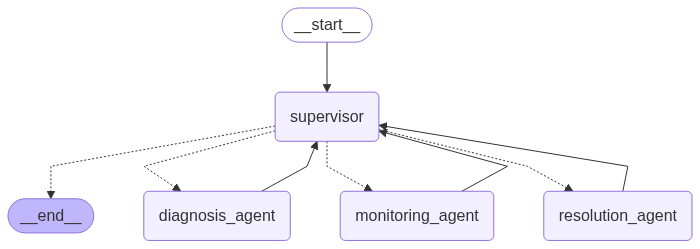

In [110]:
# review the graph
from IPython.display import display, Image

display(Image(aws_monitoring_workflow.get_graph().draw_mermaid_png()))

### Invoke the graph

In [102]:
txt = """
I want to check if my account has any security or compliance vulnerabilities. For this, 
I want to discover my iam logs for the past, let's say a week and then diagnose it. Any
help would be great!
"""

# Run the workflow
events = aws_monitoring_workflow.stream(
    {"messages": [{"role": "user", "content": txt}]}, 
    {"recursion_limit": 20}
)

# Log and save the events
logger.info(f"{Fore.MAGENTA}=== STARTING AWS MONITORING WORKFLOW ==={Style.RESET_ALL}")

with open("output.txt", "a") as file:
    from datetime import datetime
    
    if events is not None:
        for event in events:
            # Log the node being executed
            for node_name, node_output in event.items():
                logger.info(f"{Fore.CYAN}[NODE: {node_name}]{Style.RESET_ALL}")
                
                # Special handling for supervisor node
                if node_name == "supervisor":
                    workflow_state = node_output.get("workflow", {})
                    logger.info(f"{Fore.MAGENTA}Workflow State: {workflow_state}{Style.RESET_ALL}")
                else:
                    # For agent nodes, pretty print the messages
                    pretty_print_messages(node_output)
                
                # Save to file
                file.write(f"{datetime.now()} - {node_name}: {str(node_output)}\n")
    else:
        error_msg = "Workflow events stream is None"
        logger.error(error_msg)
        file.write(f"{datetime.now()} - ERROR: {error_msg}\n")

logger.info(f"{Fore.MAGENTA}=== WORKFLOW COMPLETE ==={Style.RESET_ALL}")

Supervisor routing to: monitoring_agent
Workflow state: {'current_step': 'monitoring_agent', 'monitoring_complete': False, 'diagnosis_complete': False, 'resolution_complete': False, 'jira_ticket_created': False}


Fetching logs for the service: ['/aws/cloudtrail']
fetching logs for log group /aws/cloudtrail/iam-events: {'logStreams': [{'logStreamName': '946538336216_CloudTrail_us-east-1_4', 'creationTime': 1752063498040, 'firstEventTimestamp': 1752063497992, 'lastEventTimestamp': 1752069234593, 'lastIngestionTime': 1752069234606, 'uploadSequenceToken': '49039859636607920659212086242623758816801524702791726706', 'arn': 'arn:aws:logs:us-east-1:946538336216:log-group:/aws/cloudtrail/iam-events:log-stream:946538336216_CloudTrail_us-east-1_4', 'storedBytes': 0}, {'logStreamName': '946538336216_CloudTrail_us-east-1_2', 'creationTime': 1752064225013, 'firstEventTimestamp': 1752064224976, 'lastEventTimestamp': 1752069232938, 'lastIngestionTime': 1752069232953, 'uploadSequenceToken': '49039859636607918461998209210157822075582629354573264442', 'arn': 'arn:aws:logs:us-east-1:946538336216:log-group:/aws/cloudtrail/iam-events:log-stream:946538336216_CloudTrail_us-east-1_2', 'storedBytes': 0}, {'logStreamName

In [114]:
## TEST 2
txt = """
I want to check if my account has any security or compliance vulnerabilities. For this, 
I want to discover my iam logs for the past, let's say a week and then diagnose it. Any
help would be great!
"""

# Run the workflow
events = aws_monitoring_workflow.stream(
    {"messages": [{"role": "user", "content": txt}]}, 
    {"recursion_limit": 20}
)

# Log and save the events
logger.info(f"{Fore.MAGENTA}=== STARTING AWS MONITORING WORKFLOW ==={Style.RESET_ALL}")

with open("output.txt", "a") as file:
    from datetime import datetime
    
    if events is not None:
        for event in events:
            # Log the node being executed
            for node_name, node_output in event.items():
                logger.info(f"{Fore.CYAN}[NODE: {node_name}]{Style.RESET_ALL}")
                
                # Special handling for supervisor node
                if node_name == "supervisor":
                    workflow_state = node_output.get("workflow", {})
                    logger.info(f"{Fore.MAGENTA}Workflow State: {workflow_state}{Style.RESET_ALL}")
                else:
                    # For agent nodes, pretty print the messages
                    pretty_print_messages(node_output)
                
                # Save to file
                file.write(f"{datetime.now()} - {node_name}: {str(node_output)}\n")
    else:
        error_msg = "Workflow events stream is None"
        logger.error(error_msg)
        file.write(f"{datetime.now()} - ERROR: {error_msg}\n")

logger.info(f"{Fore.MAGENTA}=== WORKFLOW COMPLETE ==={Style.RESET_ALL}")

Supervisor routing to: monitoring_agent
Workflow state: {'current_step': 'monitoring_agent', 'monitoring_complete': False, 'diagnosis_complete': False, 'resolution_complete': False, 'jira_ticket_created': False}
Fetching logs for the service: ['/aws/cloudtrail']
fetching logs for log group /aws/cloudtrail/iam-events: {'logStreams': [{'logStreamName': '946538336216_CloudTrail_us-east-1', 'creationTime': 1752072929146, 'firstEventTimestamp': 1752072929102, 'lastEventTimestamp': 1752072929102, 'lastIngestionTime': 1752072929156, 'uploadSequenceToken': '49039859636612831558503902788742692278047513212838274741', 'arn': 'arn:aws:logs:us-east-1:946538336216:log-group:/aws/cloudtrail/iam-events:log-stream:946538336216_CloudTrail_us-east-1', 'storedBytes': 0}], 'ResponseMetadata': {'RequestId': 'dcaa5a13-cb8e-4f7e-8210-73234528df4e', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'dcaa5a13-cb8e-4f7e-8210-73234528df4e', 'content-type': 'application/x-amz-json-1.1', 'content-length': 

In [117]:
## TEST 3
# txt = """
# I want to check if my account has any security or compliance vulnerabilities. For this, 
# I want to discover my iam logs for the past, let's say a week and then diagnose it. Any
# help would be great!
# """

# # Run the workflow
# events = aws_monitoring_workflow.stream(
#     {"messages": [{"role": "user", "content": txt}]}, 
#     {"recursion_limit": 20}
# )

# # Log and save the events
# logger.info(f"{Fore.MAGENTA}=== STARTING AWS MONITORING WORKFLOW ==={Style.RESET_ALL}")

# with open("output.txt", "a") as file:
#     from datetime import datetime
    
#     if events is not None:
#         for event in events:
#             # Log the node being executed
#             for node_name, node_output in event.items():
#                 logger.info(f"{Fore.CYAN}[NODE: {node_name}]{Style.RESET_ALL}")
                
#                 # Special handling for supervisor node
#                 if node_name == "supervisor":
#                     workflow_state = node_output.get("workflow", {})
#                     logger.info(f"{Fore.MAGENTA}Workflow State: {workflow_state}{Style.RESET_ALL}")
#                 else:
#                     # For agent nodes, pretty print the messages
#                     pretty_print_messages(node_output)
                
#                 # Save to file
#                 file.write(f"{datetime.now()} - {node_name}: {str(node_output)}\n")
#     else:
#         error_msg = "Workflow events stream is None"
#         logger.error(error_msg)
#         file.write(f"{datetime.now()} - ERROR: {error_msg}\n")

# logger.info(f"{Fore.MAGENTA}=== WORKFLOW COMPLETE ==={Style.RESET_ALL}")

### Create a Streamlit UI
---

In [116]:
import logging
import ipywidgets as widgets
from IPython.display import display
from datetime import datetime
from colorama import Fore, Style

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def pretty_print_messages(node_output):
    """Pretty print the messages to the logger (for internal logging)."""
    for key, value in node_output.items():
        logger.info(f"    {key}: {value}")

# Create UI components
heading = widgets.HTML("<h1 style='text-align:center;'>AWS Security & Compliance Chatbot</h1><hr>")
chat_output = widgets.Output(layout={'border': '1px solid black', 'height': '300px', 'overflow_y': 'auto'})

# Create text input and send button for the bottom input area
text_input = widgets.Text(
    value="""I want to check if my account has any security or compliance vulnerabilities. For this, 
I want to discover my iam logs for the past, let's say a week and then diagnose it. Any
help would be great!""",
    placeholder="Type your message here...",
    description="",
    disabled=False,
    layout=widgets.Layout(width="80%")
)
send_button = widgets.Button(
    description="Send",
    button_style="success",
    tooltip="Click to send your query",
    icon="paper-plane",
    layout=widgets.Layout(width="20%")
)

def on_send_button_clicked(b):
    # Get user's message from the input box.
    user_msg = text_input.value.strip()
    if not user_msg:
        return  # Ignore empty messages

    # Display the user's query in the chat log.
    with chat_output:
        print(f"\nUser: {user_msg}\n")
    
    # Prepare the payload as required by your workflow.
    params = {"messages": [{"role": "user", "content": user_msg}]}
    extra_params = {"recursion_limit": 10}
    
    # Log the start of the workflow invocation.
    logger.info(f"{Fore.MAGENTA}=== STARTING AWS MONITORING WORKFLOW ==={Style.RESET_ALL}")
    
    # Run the workflow.
    events = aws_monitoring_workflow.stream(params, extra_params)
    
    # Log events and save them to file.
    with open("output.txt", "a") as file:
        if events is not None:
            for event in events:
                for node_name, node_output in event.items():
                    logger.info(f"{Fore.CYAN}[NODE: {node_name}]{Style.RESET_ALL}")
                    
                    # Display node output in the chat UI.
                    with chat_output:
                        if node_name == "supervisor":
                            workflow_state = node_output.get("workflow", {})
                            print(f"[{node_name}] Workflow State: {workflow_state}")
                        else:
                            for key, value in node_output.items():
                                print(f"[{node_name}] {key}: {value}")
                    
                    # Save the event details to a file with a timestamp.
                    file.write(f"{datetime.now()} - {node_name}: {str(node_output)}\n")
        else:
            error_msg = "Workflow events stream is None"
            logger.error(error_msg)
            with chat_output:
                print(error_msg)
            file.write(f"{datetime.now()} - ERROR: {error_msg}\n")
    
    logger.info(f"{Fore.MAGENTA}=== WORKFLOW COMPLETE ==={Style.RESET_ALL}")
    
    # Clear the input for the next query.
    text_input.value = ""

# Bind the send button to the callback.
send_button.on_click(on_send_button_clicked)

# Arrange the UI in a typical chat layout:
# 1. A header at the top.
# 2. The chat output in the middle.
# 3. An input area (text input and send button) at the bottom.
input_area = widgets.HBox([text_input, send_button])
ui = widgets.VBox([heading, chat_output, input_area])
display(ui)